# Install Prereqs

In [1]:
!pip install python-Levenshtein
!pip install fuzzywuzzy
!pip install fuzzymatcher

     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149802 sha256=e38c0232e5ba0fe3d8dc1f628ff7b69a946fb36221fea42e1def71565eccc676
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein
  Created wheel for metaphone: filename=Metaphone-0.6-cp37-none-any.whl size=13905 sha256=a2e05cf4c52b8182046aa83989dbc37e25b7ee5a86a750da85011b6632e62501
  Stored in directory: /root/.cache/pip/wheels/4e/7c/f7/162d726fc83491ef23c7a0b989005024eb83a1408c96f32eaf
Successfully built metaphone


# Upload Local Data (Coaches9.csv)

In [2]:
import pandas as pd
import numpy as np
import io
import numpy as np
from google.colab import files
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import fuzzymatcher
import re
import requests
from bs4 import BeautifulSoup
import Levenshtein as lv
from pprint import pprint
from google.colab import files
import csv
import json
import time

from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Define Supporting Functions


In [3]:
# requests a file be uploaded. converts this to dataframe and returns
def upload_csv_to_df(filename):
  uploaded = files.upload()
  keys = list(uploaded.keys())
  df = None
  if len(keys) > 0:
    filename = keys[0]
    df = pd.read_csv(io.BytesIO(uploaded[filename])) # Dataset is now stored in a Pandas Dataframe
    print(f"Loaded file: {filename} into dataframe:")
  else:
    print("ERR: no file uploaded?")
  return df
  
def save_and_download_csv(filename, rows_of_dicts):
  if len(rows_of_dicts) > 0:
    all_keys = set()
    for d in rows_of_dicts:
      all_keys = all_keys.union(set(d.keys()))
    with open(filename, 'w') as f:
      writer = csv.DictWriter(f, fieldnames=list(all_keys))
      writer.writeheader()
      writer.writerows(rows_of_dicts)
    files.download(filename)
  else:
    print("no rows to write")

def scrape_table(url, html_class='wikitable'):
  headers = {
      'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'
  }

  with requests.Session() as s:
    response = requests.get(url, headers=headers)
    print(f"Request returned {response.status_code} : '{response.reason}'")

    soup = BeautifulSoup(response.text, 'lxml')

    rows = []
    for tr in soup.find('table', class_=html_class).find_all('tr'):
      rows.append( [x.text.replace('\n', '') for x in tr.find_all(['th', 'td'])] )
  return rows



def to_numeric_df(row_list, header=[], numeric_columns=[]):
  if not header: # take from first row
    header = row_list[0]
    row_list = row_list[1::]
  tmp_df = pd.DataFrame(data=row_list, columns=header)

  for n_col in numeric_columns:
    tmp_df[n_col] = tmp_df[n_col].apply(lambda x: re.sub('[^0-9.]', '', str(x)))  # strip
    tmp_df[n_col] = pd.to_numeric(tmp_df[n_col], errors='coerce')

  return tmp_df



  import Levenshtein as lv
def find_best_match(find_me, haystack_list, prefix_list=[], suffix_list=[]):
  find_me = str(find_me)
  match_type = ''
  LV_THRESH = 0.80 # levenshtein ratios below this will not be returned
  find_me = find_me.lower()
  haystack_list = [str(w).lower() for w in haystack_list]
  prefix_list = [str(w).lower() for w in prefix_list]
  suffix_list = [str(w).lower() for w in suffix_list]

  if find_me in haystack_list:
    match_type = 'EXACT'
    return find_me

  find_me_list = [find_me]
  ps = [w+" "+find_me for w in prefix_list]
  ss = [find_me+" "+w for w in suffix_list]
  find_me_list.extend(ps)
  find_me_list.extend(ss)

  haystack_set = set(haystack_list)
  find_me_set = set(find_me_list)

  matches = list(find_me_set.intersection(haystack_set))
  sorted_matches = sorted(matches, key=lambda x: len(x))
  if len(sorted_matches) > 0:
    match_type = 'EXACT_PREFIX_POSTFIX'
    return sorted_matches[0]
  
  # let's try levenstschenietne distance (actually ratio) next
  lv_dict = {}
  for f in find_me_list:
    lv_dict_tmp = {k:lv.ratio(f, k) for k in haystack_list}
    # combine agglomerative dictionary and this dictionary, preferring higher-scoring terms
    lv_dict = {x: lv_dict.get(x,0) if lv_dict.get(x,0)>lv_dict_tmp.get(x,0) else lv_dict_tmp.get(x,0) for x in set(lv_dict).union(set(lv_dict_tmp))}

  sorted_lv = [(k,v) for k,v in sorted(lv_dict.items(), key=lambda item: item[1], reverse=True)]
  chosen_lv_name = sorted_lv[0][0] # [0][0] is key/name
  chosen_lv_score = sorted_lv[0][1] # [0][1] is lv score

  if chosen_lv_score < LV_THRESH:
    match_type = ''
    print(f"ERROR: '{find_me}' not found. Closest match '{chosen_lv_name}' (score: {chosen_lv_score}). Aborting.")
    return ''
  else:
    match_type = 'LEVENSHTEIN'
    return chosen_lv_name

# unit tests for the above function
print("TESTS to follow...")
assert find_best_match("hello", ["hi", "helloe", "hello"]) == "hello"
assert find_best_match("hello", ["hi", "helloe", "hello University"], suffix_list=["UniVerSity"]) == "hello university"
assert find_best_match("hello x", ["hi", "helloe", "hello University"], suffix_list=["UniVerSity"]) == "hello university"
assert find_best_match("hello", ["hi", "helloe", "University of hello"], prefix_list=["UniVerSity"]) == "university of hello"
print("... Ignore expected error:")
assert find_best_match("hello xwefwefwefwefwe", ["hi", "helloe", "hello University"], suffix_list=["UniVerSity"]) != "hello university"

TESTS to follow...
... Ignore expected error:
ERROR: 'hello xwefwefwefwefwe' not found. Closest match 'hello university' (score: 0.6666666666666666). Aborting.


# Upload Coaches Data (coaches.csv or coaches9.csv)

In [4]:
df = upload_csv_to_df('coaches.csv')

Saving Coaches9.csv to Coaches9.csv
Loaded file: Coaches9.csv into dataframe:


# Upload Wins/Losses, win_loss.csv (Skip this step if data scraping)

In [5]:
df_win_loss = upload_csv_to_df("win_loss.csv")

Saving win_loss.csv to win_loss.csv
Loaded file: win_loss.csv into dataframe:


# Upload Graduation Data, graduation_rates.csv (Skip this step and scrape data if not available)

In [6]:
df_grad = upload_csv_to_df("graduation_rates.csv")

Saving graduation_rates.csv to graduation_rates.csv
Loaded file: graduation_rates.csv into dataframe:


# Upload bowl_wins.csv (or skip and scrape)

In [7]:
# upload bowl wins by coach
df_bowl_wins = upload_csv_to_df("bowl_wins.csv")

Saving bowl_wins.csv to bowl_wins.csv
Loaded file: bowl_wins.csv into dataframe:


# Upload NCAA School Finances ncaa_fin.csv (or skip and scrape)

In [8]:
df_ncaa_fin = upload_csv_to_df("ncaa_fin.csv")

Saving ncaa_fin.csv to ncaa_fin.csv
Loaded file: ncaa_fin.csv into dataframe:


# Upload Revenue and Expenses data (ticket_revenue.json)

In [9]:
filename = 'ticket_revenue.json'
uploaded = files.upload()
school_data = json.load( io.BytesIO(uploaded[filename]) )


Saving ticket_revenue.json to ticket_revenue.json


# Cleaning Revenue and Expenses Data

In [10]:
# parse ticket_revenue.json into df_ticket_revenue
# this will have a cur_yr and prior_yr keys. other values are ignored
data = [] # list of dicts
for i, school in enumerate(school_data):
  try:
    d = {} # expenses
    r = {} # revenues
    d['school_name'] = school['profile']['school_name']
    for row in school['expenses_rows']:
      if row['year']['value'] == '2019':
        # parse cur_yr fields
        d['coaching_staff_expenses_cur_yr'] = row['coaching_staff']['value']
        d['scholarships_cur_yr'] = row['scholarships']['value']
        d['building_ground_expenses_cur_yr'] = row['building_grounds']['value']
        d['other_expenses_cur_yr'] = row['other']['value']
        d['total_expenses_cur_yr'] = row['total_expenses']['value']
      if row['year']['value'] == '2018':
        # parse prior_yr fields
        d['coaching_staff_expenses_prior_yr'] = row['coaching_staff']['value']
        d['scholarships_prior_yr'] = row['scholarships']['value']
        d['building_ground_expenses_prior_yr'] = row['building_grounds']['value']
        d['other_expenses_prior_yr'] = row['other']['value']
        d['total_expenses_prior_yr'] = row['total_expenses']['value']
    for row in school['revenues_rows']:
      if row['year']['value'] == '2019':
        r['ticket_sales_rev_cur_yr'] = row['ticket_sales']['value']
        r['contributions_rev_cur_yr'] = row['contributions']['value']
        r['rights_licensing_rev_cur_yr'] = row['rights_licensing']['value']
        r['student_fees_rev_cur_yr'] = row['student_fees']['value']
        r['school_funds_rev_cur_yr'] = row['school_funds']['value']
        r['other_rev_cur_yr'] = row['other']['value']
        r['total_revenues_rev_cur_yr'] = row['total_revenues']['value']
      if row['year']['value'] == '2018':
        r['ticket_sales_rev_prior_yr'] = row['ticket_sales']['value']
        r['contributions_rev_prior_yr'] = row['contributions']['value']
        r['rights_licensing_rev_prior_yr'] = row['rights_licensing']['value']
        r['student_fees_rev_prior_yr'] = row['student_fees']['value']
        r['school_funds_rev_prior_yr'] = row['school_funds']['value']
        r['other_rev_prior_yr'] = row['other']['value']
        r['total_revenues_rev_prior_yr'] = row['total_revenues']['value']
    data.append({**d, **r}) # combine d and r and then stuff into data
  except:
    print(f'Failed to parse record {i}')
print(f"{len(data)} rows of data parsed successfully")

# cleanup and format as number
if len(data) > 0:
  num_cols = list(data[0].keys())
  num_cols.remove('school_name')
  df_ticket_revenue = to_numeric_df(data, numeric_columns=num_cols)

227 rows of data parsed successfully


# Data Cleaning for Coaches Data

In [11]:
df = df.apply(lambda c: c.str.strip() if c.dtype == "object" else c) # strip whitespace where applicable
df = df.apply(lambda c: c.str.replace('$', '') if c.dtype == "object" else c) # strip $$$ where applicable
df = df.apply(lambda c: c.str.replace('--', '') if c.dtype == "object" else c) # strip -- where applicable
df = df.apply(lambda c: c.str.replace(',', '') if c.dtype == "object" else c) # strip , where applicable

# convert to float
df['SchoolPay'] = pd.to_numeric(df['SchoolPay'], errors='coerce')
df['TotalPay'] = pd.to_numeric(df['TotalPay'], errors='coerce')
df['Bonus'] = pd.to_numeric(df['Bonus'], errors='coerce')
df['BonusPaid'] = pd.to_numeric(df['BonusPaid'], errors='coerce')
df['AssistantPay'] = pd.to_numeric(df['AssistantPay'], errors='coerce')
df['Buyout'] = pd.to_numeric(df['Buyout'], errors='coerce')


# Explore Coaches Data

In [12]:
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 3)
desc = df.describe(include=np.object)
print(desc)
print('\n\n')
print(df.info()) # no nulls seen, but "--" (different from $0) exists in many BonusPaid columns, and a few Bonus column entries
print('\n\n')
print('columns with 0 values:')
print( list(zip(list(df.columns), list((df.values == 0).sum(axis=0)))) )
print('\n')
# histograms for each variable (to get a sense of the distribution of the numeric and categorical data)
[px.histogram(df, x=col_name).show() for col_name in df.columns]

                   School Conference        Coach
count                 129        129          129
unique                129         11          129
top     Northern Illinois    Big Ten  Doug Martin
freq                    1         14            1



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   School        129 non-null    object 
 1   Conference    129 non-null    object 
 2   Coach         129 non-null    object 
 3   SchoolPay     125 non-null    float64
 4   TotalPay      125 non-null    float64
 5   Bonus         107 non-null    float64
 6   BonusPaid     88 non-null     float64
 7   AssistantPay  129 non-null    int64  
 8   Buyout        107 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 9.2+ KB
None



columns with 0 values:
[('School', 0), ('Conference', 0), ('Coach', 0), ('SchoolPay', 0), ('TotalPay

[None, None, None, None, None, None, None, None, None]

# Clean/analyze Relevant Columns of Graduation Data

In [13]:
df_grad = df_grad.drop(['sportCode', 'orgId', 'gsrReportLink', 'fgrReportLink'], axis=1, errors='ignore')
x0 = df_grad['fgr']
x1 = df_grad['gsr']
df_hist = pd.DataFrame(dict(
    series = np.concatenate((["fgr"]*len(x0), ["gsr"]*len(x1))), 
    data = np.concatenate((x0,x1))
))
px.histogram(df_hist, x="data", color="series", barmode="overlay")

# Combine Graduation Data

In [14]:
df_all = df

In [15]:
# df_all(School) <- df_grad(orgName)
df_grad['orgName'] = df_grad['orgName'].apply(lambda x: re.sub('(University)|(of)', '', x) )
df_all = fuzzymatcher.fuzzy_left_join(df_all, df_grad, 'School', 'orgName')
df_all = df_all.drop(columns=['best_match_score', '__id_left', '__id_right'])

# Combine Career Win/Loss Records to Coaches (Main Data)

In [16]:
# df.head() # School	Conference	Coach	SchoolPay	TotalPay	Bonus	BonusPaid	AssistantPay	Buyout
# df_win_loss.head() # School	Conference	Head coach	First season	Wx	Lx	Wpctx	W	L	Wpct	Offensive coordinators...
# join df_win_loss into df using left join: df <- df_win_loss on columns "Coach" <- "Head coach"
#flex_left_join(df, df_win_loss, "Coach", "Head coach").head()
df_all = fuzzymatcher.fuzzy_left_join(df_all, df_win_loss, 'Coach', 'Head coach')
df_all = df_all.drop(columns=['best_match_score', '__id_left', '__id_right'])
df_all = df_all.rename(columns={'School_left':'School', 
                       'Conference_left': 'Conference',
                       'School_right': 'School_1',
                       'Conference_right': 'Conference_1'})

# Combine ticket_revenue into main data

In [17]:
# this data is also from the NCAA but it is from many subpages
df_all = fuzzymatcher.fuzzy_left_join(df_all, df_ticket_revenue, 'School', 'school_name')
df_all = df_all.drop(columns=['best_match_score', '__id_left', '__id_right'])

# Combine NCAA School Finances

In [18]:
df_all = fuzzymatcher.fuzzy_left_join(df_all, df_ncaa_fin, 'School', 'School')
df_all = df_all.drop(columns=['best_match_score', '__id_left', '__id_right'])
df_all = df_all.rename(columns={'School_left':'School', 
                      'School_right': 'School_2'})

# Combine Coach Bowl Wins (bowl_wins.csv)

In [19]:
df_all = fuzzymatcher.fuzzy_left_join(df_all, df_bowl_wins, 'Coach', 'Coach')
df_all = df_all.drop(columns=['best_match_score', '__id_left', '__id_right'])
df_all = df_all.rename(columns={'Coach_left':'Coach', 
                      'Coach_right': 'Coach_1',
                      'School_left': 'School',
                      'School_right': 'School_3'})

# What percentage of each dataset was able to be merged?

In [20]:
# [df_name, count_left, len(right), pct_merged]
merged = []
merged.append([
  'df_bowl_wins', 
  len(df_bowl_wins) - np.isnan(df_all['coach_bowl_pct']).sum(), 
  len(df_bowl_wins),
  1 - (np.isnan(df_all['coach_bowl_pct']).sum() / len(df_bowl_wins))
])
try:
  merged.append([
    'df_ncaa_fin',
    len(df_ncaa_fin) - np.isnan(df_all['Total Revenue']).sum(),
    len(df_ncaa_fin),
    1 - (np.isnan(df_all['Total Revenue']).sum() / len(df_ncaa_fin))
  ])
except:
  pass # re-running this after column renames will give keyvalue error
merged.append([
  'df_grad',
  len(df_grad) - np.isnan(df_all['gsr']).sum(),
  len(df_grad),
  1 - (np.isnan(df_all['gsr']).sum() / len(df_grad))
])
merged.append([
  'df_win_loss',
  len(df_win_loss) - np.isnan(df_all['Wpct']).sum(),
  len(df_win_loss),
  1 - (np.isnan(df_win_loss['Wpct']).sum() / len(df_win_loss))
])
merged.append([
  'df_ticket_revenue',
  len(df_ticket_revenue) - np.isnan(df_all['total_expenses_cur_yr']).sum(),
  len(df_ticket_revenue),
  1 - (np.isnan(df_ticket_revenue['total_expenses_cur_yr']).sum() / len(df_ticket_revenue))
])

from pprint import pprint
pprint(merged)


[['df_bowl_wins', 21, 83, 0.2530120481927711],
 ['df_ncaa_fin', 213, 228, 0.9342105263157895],
 ['df_grad', 110, 129, 0.8527131782945736],
 ['df_win_loss', 113, 130, 0.9615384615384616],
 ['df_ticket_revenue', 211, 226, 1.0]]


# Compute Missing Values

In [21]:
# df_bowl_wins for each missing coach can be assumed 0 (none)
# df_ncaa_fin missing values should be filled with median for each school (~7% are affected)
# df_grad grade missing values should be filled with median (~20% of total are like this)
# df_win_loss missing values should be filled with median (~4% of total are like this)
# this is all modifications to df_all
def fill_missing_vals(df, zeroing_cols=[], median_cols=[]):
  # You do realize why this is in a function and run over both the test AND training data
  # separately. Don't you? The median values must be computed independently, or else the
  # test data will be contaminated through missing values with special information about
  # the training data

  df_plz_atomic = df.copy(deep=True) # don't mess up my data!
  # zeroing out missing df_bowl_wins
  for col in zeroing_cols:
    df_plz_atomic[col] = df_plz_atomic[col].fillna(0)

  # medians
  # compute medians by conference for all columns
  medians = df_all.groupby('Conference').median() # ticket_sales_rev_cur_yr
  medians = medians.reset_index()
  
  x = 0
  for col in median_cols:
    # only attempt this on a NUMERIC column with missing values
    if df_plz_atomic.dtypes[col] == np.float64 and np.isnan(df_plz_atomic[col]).sum() > 0:
      x += 1
      df_plz_atomic[col] = df_plz_atomic.apply(
          lambda row: medians[medians['Conference'] == row['Conference']][col] if np.isnan(row[col]) else row[col],
          axis=1
      )
      #df_plz_atomic[col] = pd.to_numeric(df_plz_atomic[col], errors='coerce') # convert to numeric (again)
      df_plz_atomic[col] = df_plz_atomic[col].astype('float64', errors='raise') # convert to numeric (again)v
  print(f"updated {x} out of {len(median_cols)} columns containing empty rows")
  return df_plz_atomic


# fff = ['Total_Allocated', 'Total_Revenue', 'Total_Expenses',
#                   'fgr', 'gsr', 
#                   'Wpct', 'W', 'L',
#                   'ticket_sales_rev_cur_yr', 'student_fees_rev_prior_yr', 'ticket_sales_diff', 'coaching_staff_expenses_cur_yr', 'coaching_staff_expenses_prior_yr','scholarships_cur_yr', 'scholarships_prior_yr', 'coaching_staff_expenses_cur_yr', 'coaching_staff_expenses_prior_yr']

# tmp_df = fill_missing_vals(df_all, median_cols=fff)
# tmp_df[tmp_df['School'] == 'Syracuse'][['ticket_sales_rev_cur_yr', 'student_fees_rev_prior_yr']]


# Add Computed Columns

In [22]:
# add a few computed columns
df_all['coach_has_bowl_participation'] = df_all.apply(lambda x: x['coach_bowl_win'] > 0 or x['coach_bowl_loss'] > 0, axis=1)
df_all['coach_has_bowl_win'] = df_all.apply(lambda x: x['coach_bowl_win'] > 0, axis=1)
#df_all['coach_bowl_win'] > 0 or df_all['coach_bowl_loss'] > 0
#df_all['coach_has_bowl_participation'] 
#df_all['coach_has_bowl_win']

df_all['scholarships_diff'] = df_all['scholarships_cur_yr'] - df_all['scholarships_prior_yr']
df_all['total_expenses_diff'] = df_all['total_expenses_cur_yr'] - df_all['total_expenses_prior_yr']
df_all['ticket_sales_diff'] = df_all['ticket_sales_rev_cur_yr'] - df_all['ticket_sales_rev_prior_yr']

In [23]:
# Remove spaces from column names, for our poor models they cannot handle it
df_all = df_all.rename(
  columns = dict(list(zip(
      list(df_all.columns), 
      [x.replace(' ', '_') for x in list(df_all.columns) ]
      )))
)



# Data Exploration by Conference

In [24]:
px.box(df_all, x='Conference', y='SchoolPay', points="all").show()
px.box(df_all, x='Conference', y='fgr', points="all").show()
px.box(df_all, x='Conference', y='gsr', points="all").show()
px.box(df_all, x='Conference', y='Total_Revenue', points="all").show()
#px.box(df_all, x='Conference', y='coach_bowl_win').show()
px.box(df_all, x='Conference', y='Wpct', points="all").show()
px.box(df_all, x='Conference', y='scholarships_cur_yr', points="all").show()
px.box(df_all, x='Conference', y='ticket_sales_diff', points="all").show()
px.box(df_all, x='Conference', y='ticket_sales_rev_cur_yr', points="all").show()
px.box(df_all, x='Conference', y='total_expenses_diff', points="all").show()

# Models!
The coach's salary will be the reponse variable: SchoolPay

In [25]:
# test/train split
np.random.seed(2299)
df_all['split_rng'] = uniform.rvs(loc=0, scale=1, size=len(df_all))
df_all_test = df_all[df_all['split_rng'] < 0.25]
df_all_train = df_all[df_all['split_rng'] >= 0.25]

print('Testing data frame shape:', df_all_test.shape)
print('Training data frame shape:', df_all_train.shape)

Testing data frame shape: (34, 76)
Training data frame shape: (95, 76)


In [26]:
# NOW adjust for missing values in the data (must be done separately, as medians are calculated over entire data)
zeroed_cols = ['coach_bowl_pct', 'coach_bowl_win', 'coach_bowl_loss', 'coach_bowl_tie'],
median_cols = ['Total_Allocated', 'Total_Revenue', 'Total_Expenses',
                  'fgr', 'gsr', 
                  'Wpct', 'W', 'L',
                  'ticket_sales_rev_cur_yr', 'student_fees_rev_prior_yr', 'ticket_sales_diff', 'coaching_staff_expenses_cur_yr', 'coaching_staff_expenses_prior_yr', 'scholarships_cur_yr', 'scholarships_prior_yr', 'coaching_staff_expenses_cur_yr', 'coaching_staff_expenses_prior_yr']

df_all_test = fill_missing_vals(df_all_test, zeroed_cols, median_cols)
df_all_train = fill_missing_vals(df_all_train, zeroed_cols, median_cols)


updated 15 out of 17 columns containing empty rows
updated 15 out of 17 columns containing empty rows


In [27]:
#df_all_test.set_index('School')
#df_all_train.set_index('School')


In [28]:



model_str = str('SchoolPay ~ Conference + W + L + ticket_sales_rev_cur_yr')
# SchoolPay ~ Conference + W + L == 0.770
# SchoolPay ~ Conference + W + L + Total_Revenue == 0.813
# SchoolPay ~ Conference + W + L + ticket_sales_rev_cur_yr == 0.830
# SchoolPay ~ Conference + W + L + ticket_sales_rev_cur_yr + gsr == 0.832* note that gsr was not found to be significant@a=0.05

# Total_Revenue p=0.0 (sus)
# coach_bowl_pct p=0.054 
# coach_has_bowl_participation[T.True] p=0.090
# coach_has_bowl_participation p=.9
# fgr + gsr

# fit the model to the training set
model_train_fit = smf.ols(model_str, data=df_all_train).fit()
# summary of model fit to the training set
print(model_train_fit.summary())
# training set predictions from the model fit to the training set
df_all_train['predict_SchoolPay'] = model_train_fit.fittedvalues

# test set predictions from the model fit to the training set
df_all_test['predict_SchoolPay'] = model_train_fit.predict(df_all_test)


print('\nProportion of Test Set Variance Accounted for: ',
      round(np.power(df_all_test['predict_SchoolPay'].corr(df_all_test['SchoolPay']),2),3))  # adj-r^2 of 0.830 yielded 0.713
print('\n\n\n')

                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     32.88
Date:                Fri, 19 Mar 2021   Prob (F-statistic):           1.11e-26
Time:                        00:44:12   Log-Likelihood:                -1406.7
No. Observations:                  94   AIC:                             2841.
Df Residuals:                      80   BIC:                             2877.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

In [29]:
# The largest coefficients are (per unit of change):
importance = model_train_fit.params.abs().sort_values(ascending=False)
importance

Conference[T.SEC]          1.588e+06
Intercept                  1.392e+06
Conference[T.Big Ten]      1.386e+06
Conference[T.ACC]          1.159e+06
Conference[T.MAC]          8.856e+05
Conference[T.Sun Belt]     8.527e+05
Conference[T.Big 12]       7.930e+05
Conference[T.C-USA]        6.771e+05
Conference[T.Mt. West]     5.460e+05
Conference[T.Pac-12]       3.324e+05
Conference[T.Ind.]         2.959e+05
L                          2.122e+04
W                          1.809e+04
ticket_sales_rev_cur_yr    4.293e-02
dtype: float64

In [30]:
# measurements of model fitness. Influence plot
#fig = sm.graphics.influence_plot(model_train_fit, criterion="cooks")
#fig.tight_layout(pad=1.0)

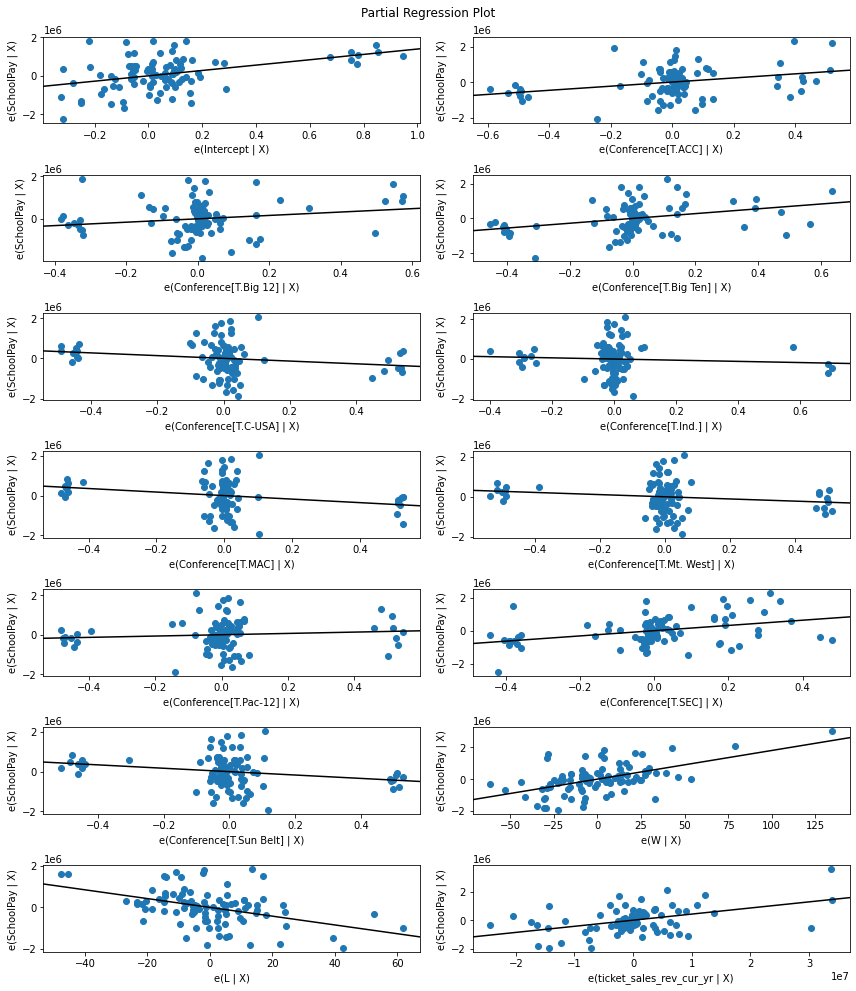

In [31]:
# plot of partial regressors
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 14))
fig = sm.graphics.plot_partregress_grid(model_train_fit, fig=fig)
plt.show()


# Dino Babers Salary Prediction

In [32]:
# calculate Syracuse University's Coach's "actual" salary
df_baber_test = df_all_train[df_all_train['Coach'] == 'Dino Babers']
baber_salary = model_train_fit.predict(df_baber_test)
baber_salary = round(list(baber_salary)[0], 0)
print("Actual salary for Dino Babers is $2,401,000")
print(f"Projected salary is ${baber_salary}")

Actual salary for Dino Babers is $2,401,000
Projected salary is $3382053.0


In [33]:
# What if Syracuse was still in the Big East conference (defunct conference)

# adjust test dataset to put Syracuse in the 'Sun Belt' (stand-in for Big East)
df_baber_sun_belt_test = df_baber_test.copy()
df_baber_sun_belt_test['Conference'] = 'Sun Belt'

# re-run predictions
baber_sun_belt_salary = model_train_fit.predict(df_baber_sun_belt_test)
baber_sun_belt_salary = round(list(baber_sun_belt_salary)[0], 0)
print(f"Dino Barber's projected salary if playing in the Sun Belt (stand-in for Big East) is ${baber_sun_belt_salary}")

Dino Barber's projected salary if playing in the Sun Belt (stand-in for Big East) is $1370735.0


In [43]:
# What would Dino Babers' salary be if Syracuse was in the Big Ten?

# adjust test dataset to put Syracuse in the 'Big Ten'
df_baber_big_ten_test = df_baber_test.copy()
df_baber_big_ten_test['Conference'] = 'Big Ten'

#df_baber_big_ten_test['W'] = 1000000.0

# re-run predictions
baber_big_ten_salary = model_train_fit.predict(df_baber_big_ten_test)
baber_big_ten_salary = round(list(baber_big_ten_salary)[0], 0)
print(f"Dino Barber's projected salary if playing in the Big Ten is ${baber_big_ten_salary}")

Dino Barber's projected salary if playing in the Big Ten is $3609522.0


# Data Scrape Code Follows
(Do not run unless scraping data from the web is required)

In [44]:
stop here

SyntaxError: ignored

# Scrape for Graduation Data (do not run if CSV was uploaded)

In [ ]:
import requests
import pprint
from bs4 import BeautifulSoup
import Levenshtein as lv

url = r'https://web3.ncaa.org/aprsearch/gsrsearch'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'
}

with requests.Session() as s:
  response = requests.get(url, headers=headers)
  print(f"Request returned {response.status_code} : '{response.reason}'")

  soup = BeautifulSoup(response.text, 'lxml')
  csrf = soup.find('meta', {'name': '_csrf'})['content']
  print(f"csrf token found: {csrf}")

  headers2 = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36',
    'Referrer': 'https://web3.ncaa.org/aprsearch/gsrsearch',
    'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
    'Host': 'web3.ncaa.org',
    'Origin': 'https://web3.ncaa.org',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Dest': 'empty',
    'X-Requested-With': 'XMLHttpRequest',
    'DNT': '1',
    'Accept': 'application/json, text/javascript, */*; q=0.01',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
    'Connection': 'keep-alive',
    'X-CSRF-TOKEN': csrf,
    'cookie': '; '.join([x.name + '=' + x.value for x in response.cookies])
    
  }

  options = soup.find("select", {"id": "school"}).findAll("option")
  options_id = [o['value'] for o in options]
  options_text = [o.text.lower() for o in options]
  options_dict = dict(zip(options_text, options_id))

  search_results = []
  not_found = []
  warnings = []
  failed_responses = []
  school_list = list(df['School'])
  #### LOOP HERE. CSRF TOKEN IS VALID FOR SESSION ########
  for i, school in enumerate(school_list):
    find_me = school.lower()
    final_schoolOrgId = 0

    best_match = find_best_match(find_me, options_dict.keys(), prefix_list=["state university of", "university of"], suffix_list=["university", "state university"])

    # found the right value in options_dict anyways
    final_schoolOrgId = options_dict.get(best_match, 'NOTFOUND_2')
    if final_schoolOrgId == '':
      print(f"DID NOT FIND {find_me}")

    form_data = {
      'schoolOrgId': final_schoolOrgId,
      'conferenceOrgId': '',  # intentionally blank
      'sportCode': 'MFB',     # always football
      'cohortYear': '2006',   # 2006-2007 year, even though cohortYear=2000
      'state': '',            # intentionally blank
      '_csrf': csrf           # cross-site request forgery value (avoids 403)
    }

    search_response = requests.post(url, data=form_data, headers=headers2)
    payload = search_response.json() 
    if payload and len(payload) > 0:
      search_results.append(payload[0])
    else:
      print(f'ERROR: [{i}] {find_me} no search results found')
      search_results.append({'orgName': find_me})
      failed_responses.append(find_me)

# and also take this data and convert it to a df
df_grad = pd.DataFrame(search_results) # may need tweaking

# download/save scrapings for NCAA
save_and_download_csv('graduation_rates.csv', search_results)

# Scrape Wikipedia for Coach Win/Loss records (win_loss.csv)

In [ ]:
rows = scrape_table(r'https://en.wikipedia.org/wiki/List_of_current_NCAA_Division_I_FBS_football_coaches')

# convert to dataframe
r = re.compile('[^a-zA-Z ]')
header = [r.sub('', x) for x in rows[0]]
# rename duplicate columns
header[4] = 'Wx'
header[5] = 'Lx'
header[6] = 'Wpctx'
header[9] = 'Wpct'

df_win_loss = pd.DataFrame(data=rows[2:], columns=header)

# convert Capacity to numeric
for col in ['W', 'L', 'Wpct']:
  df_win_loss[col] = pd.to_numeric(df_win_loss[col], errors='coerce')
print(df_win_loss.head())

# save and download .csv for later use
save_and_download_csv('win_loss.csv', df_win_loss.to_dict('records'))

# Scrape Coach Bowl Wins (bowl_wins.csv)

In [ ]:
 
rows = scrape_table(r'https://www.sports-reference.com/cfb/leaders/win-loss-pct-post-coach-career.html', 'stats_table')
df_bowl_wins = to_numeric_df(rows, [], ['Rk', 'Pct', 'W', 'L', 'T'])
# remove asterisks and outside whitespaces from Coach column
df_bowl_wins['Coach'] = df_bowl_wins['Coach'].apply(lambda x: re.sub('[*]', '', str(x)).strip() )
df_bowl_wins = df_bowl_wins.rename(columns={
    'W': 'coach_bowl_win',
    'L': 'coach_bowl_loss',
    'T': 'coach_bowl_tie',
    'Pct': 'coach_bowl_pct',
    'Rk': 'coach_bowl_rank'
})
print(df_bowl_wins.head())

# save and download .csv for later use
save_and_download_csv('bowl_wins.csv', df_bowl_wins.to_dict('records'))

# Scrape for Total Finance for Each School (ncaa_fin.csv)

In [ ]:
rows = scrape_table(r'https://sports.usatoday.com/ncaa/finances/', 'datatable-finances')
df_ncaa_fin = to_numeric_df(rows, [], ['Rk', 'Total Revenue','Total Expenses', 'Total Allocated', '% Allocated'])
print(df_ncaa_fin.head())

# save and download .csv for later use
save_and_download_csv('ncaa_fin.csv', df_ncaa_fin.to_dict('records'))

# Scrape for Scholarship, Ticket, and Total Revenue and Expenses for Current and Past Years (ticket_revenue.json) SLOW

In [ ]:

# scrape more details about finances: ticket revenue and so on, by year
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'
}

with requests.Session() as s:
  response = requests.get(r'https://sports.usatoday.com/ncaa/finances/', headers=headers)
  print(f"Request returned {response.status_code} : '{response.reason}'")

  soup = BeautifulSoup(response.text, 'lxml')
  passids = set([])
  tds = soup.find_all('td')
  for td in tds:
    if 'data-passid' in td.attrs:
      passids.add(td.attrs['data-passid'])

  print(passids)
  print(len(passids))

  school_data = []
  for passid in passids:
    print(f"requesting {passid}...")
    resp2 = requests.get(r'https://sports.usatoday.com/ajaxservice/ncaa/finances__school__'+passid, headers=headers)
    data = json.loads(resp2.text)
    school_data.append(data)
    time.sleep(0.5)

# save ticket_revenue.json
ticket_revenue_filename = 'ticket_revenue.json'
with open(ticket_revenue_filename, 'w') as f:
  json.dump(school_data, f, indent=2)
  files.download(ticket_revenue_filename)

# CODE APPENDIX FOLLOWS ... --- DO NOT RUN CODE BELOW ---

# Same NCAA Scraping, but With Selenium (Slower)

In [ ]:
!pip install turicreate
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
from selenium.webdriver.support.select import Select 

In [ ]:
wd.set_window_position(0, 0)
wd.set_window_size(1920, 1080)
wd.get("http://web3.ncaa.org/aprsearch/gsrsearch")


In [ ]:
def screenshot(wd):
  screenshot_filename = "".join([c for c in wd.title if c.isalpha() or c.isdigit() or c==' ']).rstrip() + ".png"
  wd.save_screenshot(screenshot_filename)
  img = turicreate.Image(screenshot_filename)
  img.show()

def extract_school_data(school_list, take_screenshot=True):
  results = []
  first_run = True
  for i, school in enumerate(school_list):
    find_me = school.lower()

    # School
    select_school = Select(wd.find_element_by_id("school")) 
    all_options = [x.text.lower() for x in select_school.options]
    indices = [j for j, s in enumerate(all_options) if find_me in s]
    if not len(indices) > 0:
      print(f"Couldn't find school [{i}]: {school}")
      results.append([])
      continue # nothing more can be done
    select_school.select_by_index(indices[0])

    # Sport
    Select(wd.find_element_by_id("sportCode")).select_by_index(4) # Football

    # Year
    Select(wd.find_element_by_id("year")).select_by_value("2000") # value is 2000 but displayed text is "2006-2007"

    wd.execute_script("search();")
    if not len(results) > 0:
      heads = wd.find_elements_by_xpath("//table/thead/tr[1]/th")
      heads = [h.text for h in heads]
      results.append(heads)
    body = wd.find_elements_by_xpath("//table/tbody/tr[1]/td")
    body = [b.text for b in body]
    results.append(body)
    if first_run and take_screenshot:
      first_run = False
      screenshot(wd)
  return results

In [ ]:
school_grades = extract_school_data( list(df['School']) )
save_and_download_csv('school_grades.csv', school_grades)


# Upload Stadium Sizes Data stadium_sizes.csv (Skip this step and scrape data if not available)

In [ ]:
df_stadiums = upload_csv_to_df("stadium_sizes.csv")

# Scrape Wikipedia for Stadium Sizes (do not run if CSV was uploaded)


In [ ]:

#url = r'https://en.wikipedia.org/wiki/List_of_American_football_stadiums_by_capacity' # variable: "Capacity"
#url = r'https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_stadiums' # variable: "Capacity" (same) also "Team"

rows = scrape_table(r'https://en.wikipedia.org/wiki/List_of_American_football_stadiums_by_capacity')

# convert to dataframe
df_stadiums = pd.DataFrame(data=rows[1::1], columns=rows[0])
# convert Capacity to numeric
df_stadiums['Capacity'] = df_stadiums['Capacity'].str.replace(',', '') # strip ,
df_stadiums['Capacity'] = pd.to_numeric(df_stadiums['Capacity'], errors='coerce')
df_stadiums.head()

# save and download .csv for later use
save_and_download_csv('stadium_sizes.csv', df_stadiums.to_dict('records'))